# AGC + calver coffea on coffea-casa

We'll base this on a few sources:
- https://github.com/iris-hep/analysis-grand-challenge/tree/main/analyses/cms-open-data-ttbar (AGC, of course)
- https://github.com/alexander-held/CompHEP-2023-AGC (contains a simplified version of AGC)
- https://github.com/nsmith-/TTGamma_LongExercise/ (credit Nick Smith for helpful examples of the new API)
- (and if time allows, weight features: https://github.com/CoffeaTeam/coffea/blob/backports-v0.7.x/binder/accumulators.ipynb / https://coffeateam.github.io/coffea/api/coffea.analysis_tools.Weights.html#coffea.analysis_tools.Weights.partial_weight)

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
import traceback
from dask.distributed import Client
import skhep_testdata
import pandas as pd

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import PackedSelection
from coffea import dataset_tools

import warnings

import utils
utils.plotting.set_style()

warnings.filterwarnings("ignore")
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here


client = Client("tls://localhost:8786")

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"dask: {dask.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


awkward: 2.6.3
dask-awkward: 2024.3.0
dask: 2024.4.0
uproot: 5.3.11.dev3+g2a20562
hist: 2.7.2
coffea: 2024.4.0


### Produce an AGC histogram with Dask (no coffea yet)

In [2]:
def calculate_trijet_mass(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electron[events.Electron.pt > 30 & (np.abs(events.Electron.eta) < 2.1)]
    print("Selected electrons: ", selected_electrons)
    selected_muons = events.Muon[events.Muon.pt > 30 & (np.abs(events.Muon.eta) < 2.1)]
    selected_jets = events.Jet[events.Jet.pt > 25 & (np.abs(events.Jet.eta) < 2.4)]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)

    # apply filters
    selected_jets = selected_jets[event_filters]

    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    return ak.flatten(trijet_mass)

Reading in the ROOT file, we can now create a Dask task graph for the calculations and plot that we want to make using `dask-awkward` and `hist.dask`

In [3]:
all_files = []
events_list = []

# Some files are downloaded locally:
# all_files.append(ttbar_file)
# all_files.append("root://eospublic.cern.ch//eos/root-eos/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext4-v1_80000_0007.root") # ttbar remote 533M size
# all_files.append("root://eospublic.cern.ch//eos/root-eos/AGC/rntuple/nanoAOD/TT_TuneCUETP8M1_13TeV-amcatnlo-pythia8/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root") # RNTuple remote
all_files.append("root://eospublic.cern.ch//eos/root-eos/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-amcatnlo-pythia8/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root") # TTree remote
all_files.append("/home/cms-jovyan/my_root_files/rntuple_v4.root") # RNTuple, local, with our own converter v4 


# all_files.append("/home/cms-jovyan/my_root_files/ttree/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext4-v1_80000_0007.root") # TTree ttbar original
# all_files.append("/home/cms-jovyan/my_root_files/ttree/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root") # TTree local
# all_files.append("/home/cms-jovyan/my_root_files/rntuple/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root")  # RNTuple local



def load_files_with_uproot(files):
    for fl in files:
        with uproot.open(fl) as f:
            events = f["Events"]
            events_list.append(events)
            print("File was loaded with uproot, event count: ", len(events.keys()))
            
            # NOTE: to access array: # events.arrays(["Electron_pt"])["Electron_pt"]
        
def load_files_with_coffea(files):
    for fl in files:
        events = NanoEventsFactory.from_root({fl: "Events"}, schemaclass=NanoAODSchema).events()
        events_list.append(events)
        print("File was loaded with coffea, fields count: ", len(events.fields))
        
        
load_files_with_uproot(all_files)

# load_files_with_coffea(all_files)



    



File was loaded with uproot, event count:  947
File was loaded with uproot, event count:  947


Starting cell...
TTree keys length: 947. RNTuple keys length: 947
[btagWeight_CSVV2] ak arrays are equal
[btagWeight_DeepCSVB] ak arrays are equal
[CaloMET_phi] ak arrays are equal
[CaloMET_pt] ak arrays are equal
[CaloMET_sumEt] ak arrays are equal
[ChsMET_phi] ak arrays are equal
[ChsMET_pt] ak arrays are equal
[ChsMET_sumEt] ak arrays are equal
[CorrT1METJet_area] ak comparison ERROR
tt:  [[0.359, 0.469, 0.419, 0.229], [0.499, ..., 0.499], ..., [0.379, 0.559, 0.548]] Type: 188600 * var * float32. Count of elements: 446606
rn:  [[0.359, 0.469, 0.419, 0.229], [0.499, 0.459, 0.439, 0.499], ..., [0.519]] Type: 188600 * var * float32. Count of elements: 18480
Len of rn after ravel: 18480


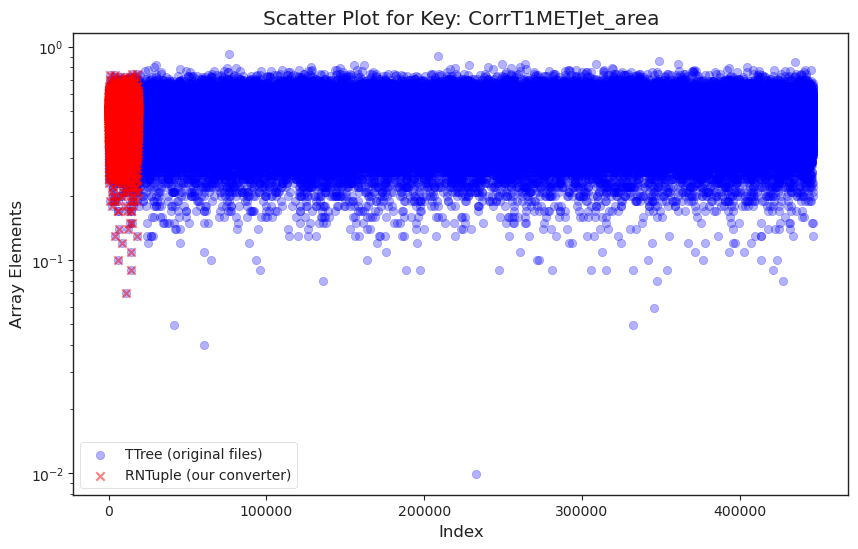

[CorrT1METJet_eta] ak comparison ERROR
tt:  [[-0.672, -1.85, -0.511, -1.6], [-3.44, ..., -4.33], ..., [0.73, -0.179, -1.51]] Type: 188600 * var * float32. Count of elements: 446606
rn:  [[-0.672, -1.85, -0.511, -1.6], [-3.44, 4.61, 3.33, -4.33], ..., [...], [-1.32]] Type: 188600 * var * float32. Count of elements: 18480
Len of rn after ravel: 18480


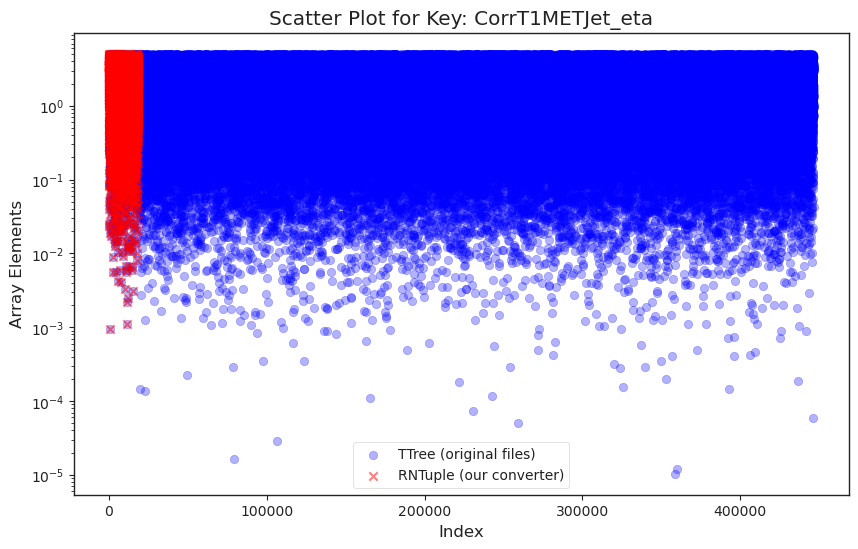

[CorrT1METJet_muonSubtrFactor] ak comparison ERROR
tt:  [[3.49e-08, -6.46e-09, -2.79e-08, 2.91e-08], ..., [-1.08e-08, ..., 8.38e-09]] Type: 188600 * var * float32. Count of elements: 446606
rn:  [[3.49e-08, -6.46e-09, -2.79e-08, 2.91e-08], [2.36e-10, ...], ..., [1.22e-08]] Type: 188600 * var * float32. Count of elements: 18480
Len of rn after ravel: 18480


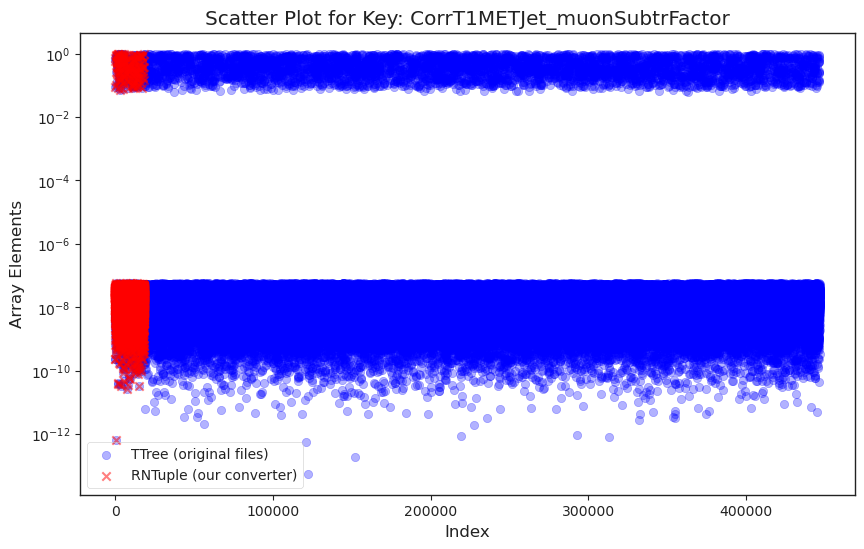

[CorrT1METJet_phi] ak comparison ERROR
tt:  [[2.49, -3, -3.09, -0.305], [1.55, 1.46, ..., -1.37], ..., [-2.81, 1.56, 0.604]] Type: 188600 * var * float32. Count of elements: 446606
rn:  [[2.49, -3, -3.09, -0.305], [1.55, 1.46, 2.34, -1.37], ..., [...], [3.13]] Type: 188600 * var * float32. Count of elements: 18480
Len of rn after ravel: 18480


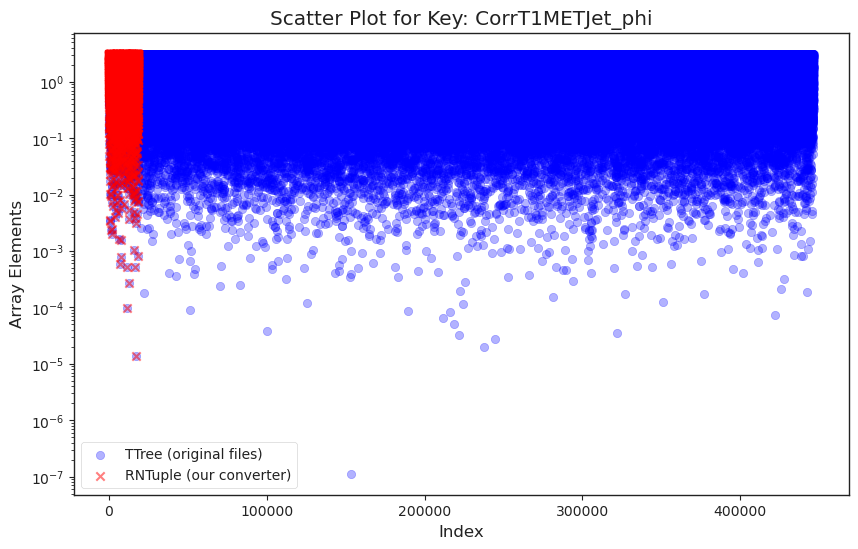

[CorrT1METJet_rawPt] ak comparison ERROR
tt:  [[12.2, 10.3, 11, 8.89], [16.5, 11.1, 14.6, 13.7], ..., [14.8, 15.4, 13.9]] Type: 188600 * var * float32. Count of elements: 446606
rn:  [[12.2, 10.3, 11, 8.89], [16.5, 11.1, 14.6, 13.7], ..., [12.7, ...], [9.58]] Type: 188600 * var * float32. Count of elements: 18480
Len of rn after ravel: 18480


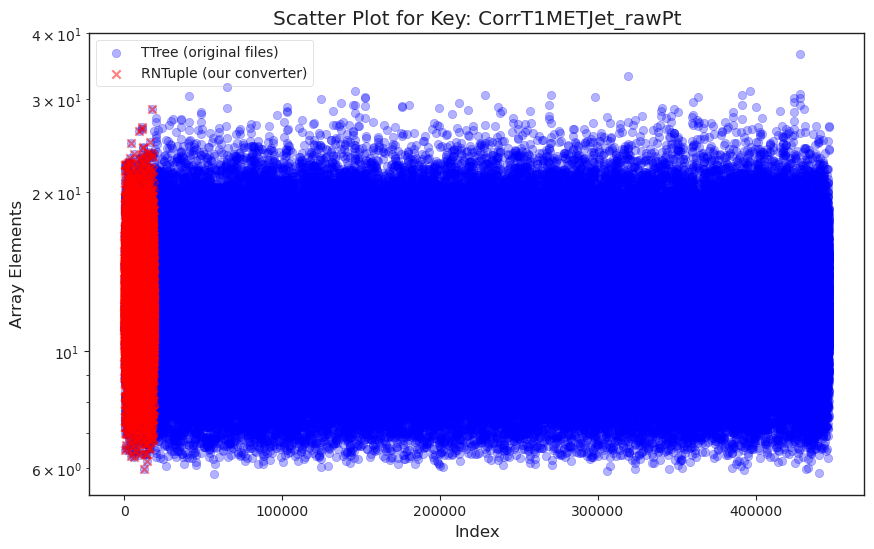

[DeepMETResolutionTune_phi] ak arrays are equal
[DeepMETResolutionTune_pt] ak arrays are equal
[DeepMETResponseTune_phi] ak arrays are equal
[DeepMETResponseTune_pt] ak arrays are equal
[Electron_charge] ak comparison ERROR
tt:  [[], [1], [-1, -1, 1, -1], [1], [1, 1], ..., [-1, 1], [1, 1], [1], [1], []] Type: 188600 * var * int32. Count of elements: 242252
rn:  [[], [1], [-1, -1, 1, -1], [1], [1, 1], ..., [-1, ...], [-1], [1], [-1], [-1]] Type: 188600 * var * int32. Count of elements: 10145
Len of rn after ravel: 10145


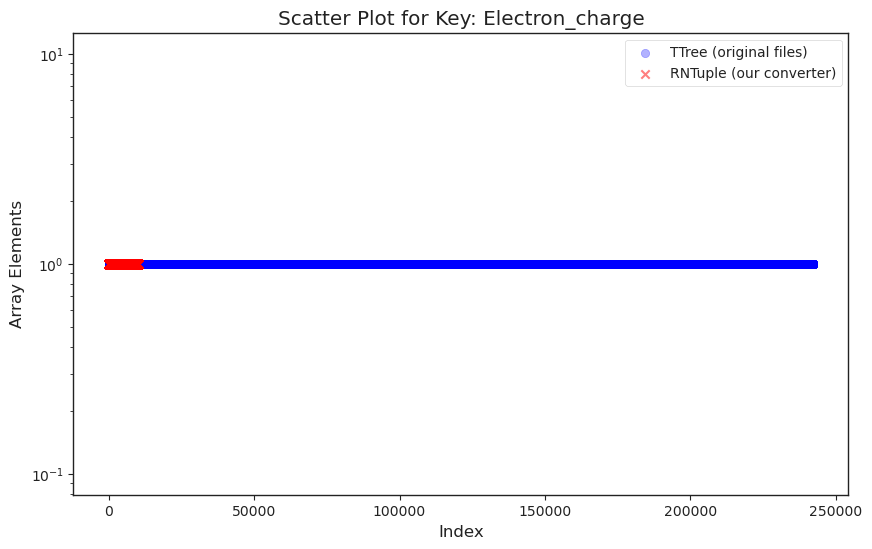

[Electron_cleanmask] ak comparison ERROR
tt:  [[], [1], [1, 1, 1, 1], [1], [1, 1], [...], ..., [1, 1], [1, 1], [1], [1], []] Type: 188600 * var * uint8. Count of elements: 242252
rn:  [[], [1], [1, 1, 1, 1], [1], [1, 1], [1, ...], ..., [1, 1], [1], [1], [1], [1]] Type: 188600 * var * uint8. Count of elements: 10145
Len of rn after ravel: 10145


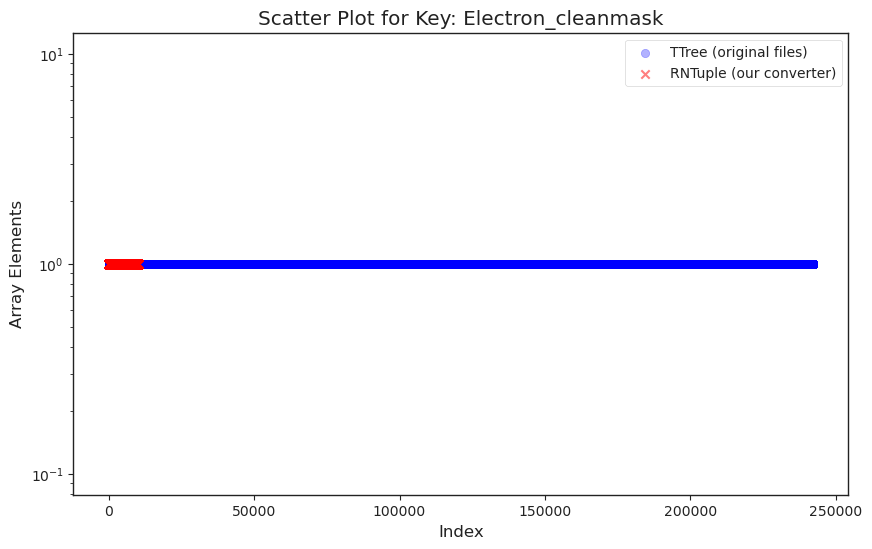

[Electron_convVeto] ak comparison ERROR
tt:  [[], [True], [True, True, True, True], [True], ..., [...], [True], [True], []] Type: 188600 * var * bool. Count of elements: 242252
rn:  [[], [True], [True, True, True, True], [True], ..., [True], [True], [True]] Type: 188600 * var * bool. Count of elements: 10145
Len of rn after ravel: 10145


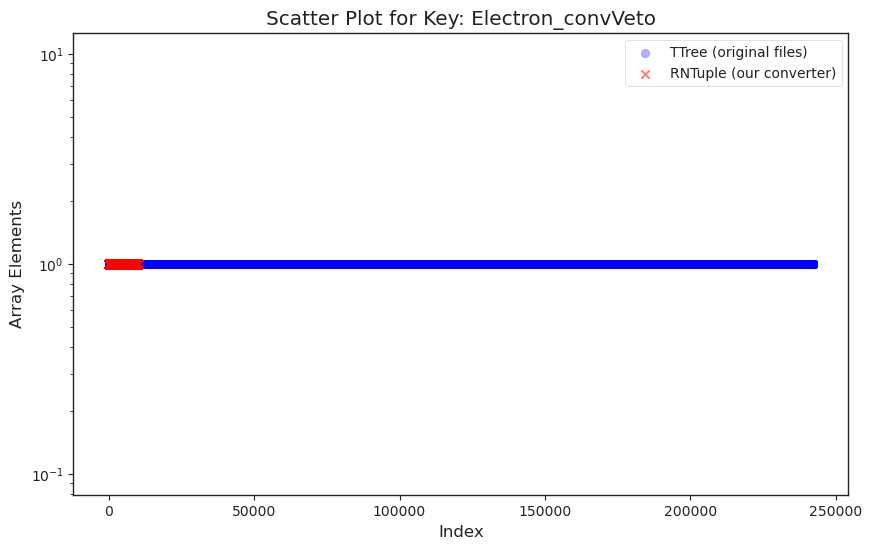

[Electron_cutBased] ak comparison ERROR
tt:  [[], [0], [0, 0, 3, 0], [4], [0, 0], [...], ..., [0, 0], [0, 0], [0], [0], []] Type: 188600 * var * int32. Count of elements: 242252
rn:  [[], [0], [0, 0, 3, 0], [4], [0, 0], [2, ...], ..., [0, 1], [1], [0], [0], [4]] Type: 188600 * var * int32. Count of elements: 10145
Len of rn after ravel: 10145


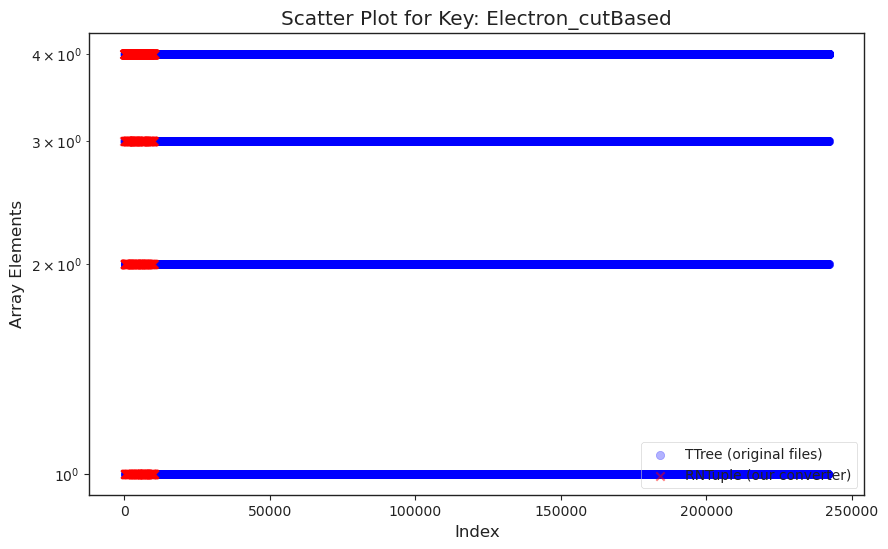

[Electron_cutBased_HEEP] ak comparison ERROR
tt:  [[], [False], [False, False, False, False], [True], ..., [False], [False], []] Type: 188600 * var * bool. Count of elements: 242252
rn:  [[], [False], [False, False, False, False], ..., [False], [False], [False]] Type: 188600 * var * bool. Count of elements: 10145
Len of rn after ravel: 10145


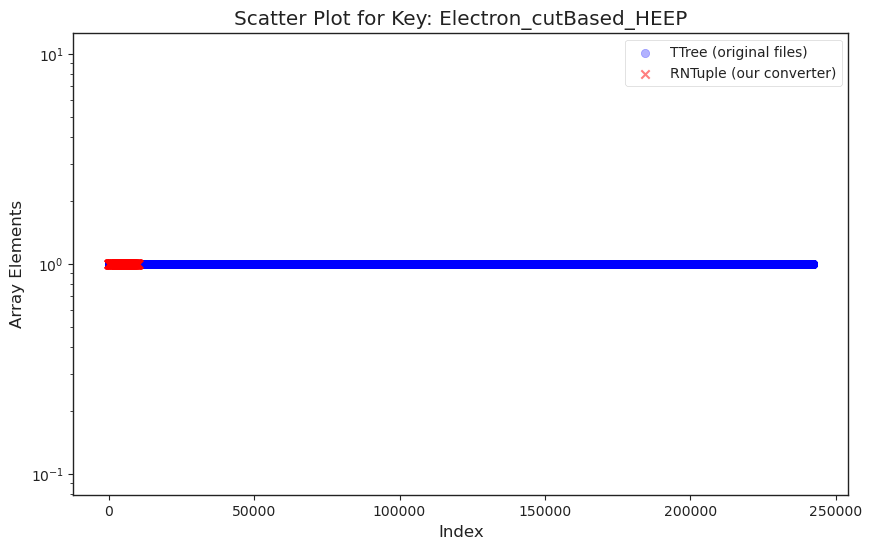

[Electron_deltaEtaSC] ak comparison ERROR
tt:  [[], [0.00021], [0.00636, 0.00554, 0.00457, 0.00352], ..., [-0.0342], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0.00021], [0.00636, 0.00554, ..., 0.00352], ..., [-0.0377], [-0.014]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


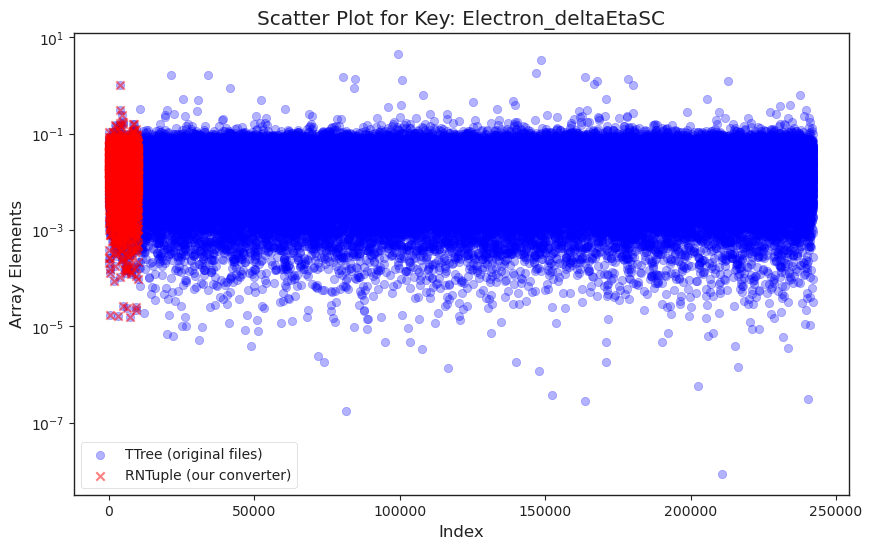

[Electron_dr03EcalRecHitSumEt] ak comparison ERROR
tt:  [[], [0], [1.95, 0, 0, 0], [0.398], [0, 0], ..., [0, ...], [0, 0], [0], [0], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0], [1.95, 0, 0, 0], [0.398], [0, 0], ..., [0, ...], [0], [0], [0], [0]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


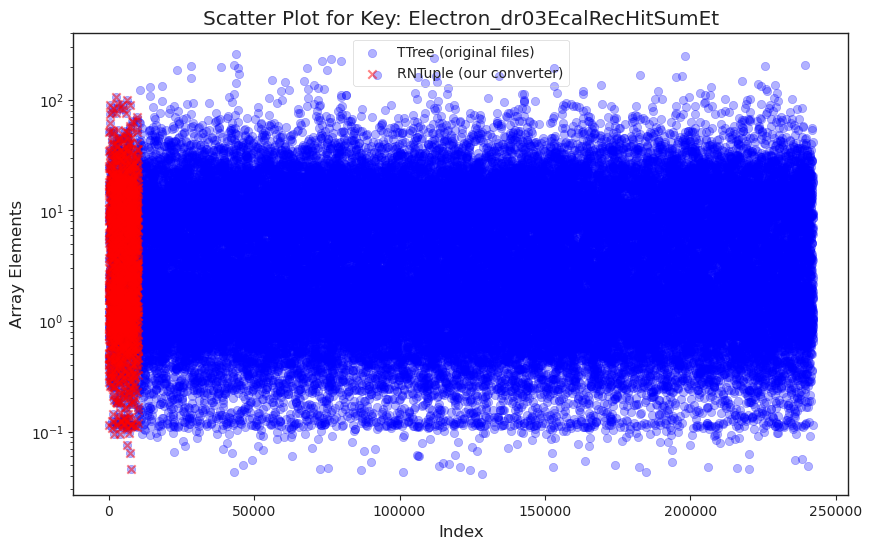

[Electron_dr03HcalDepth1TowerSumEt] ak comparison ERROR
tt:  [[], [0], [5.2, 0, 0, 0], [0.504], [0, 0], ..., [0, ...], [0, 0], [0], [0], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0], [5.2, 0, 0, 0], [0.504], [0, 0], ..., [0, 0], [0], [0], [0], [0]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


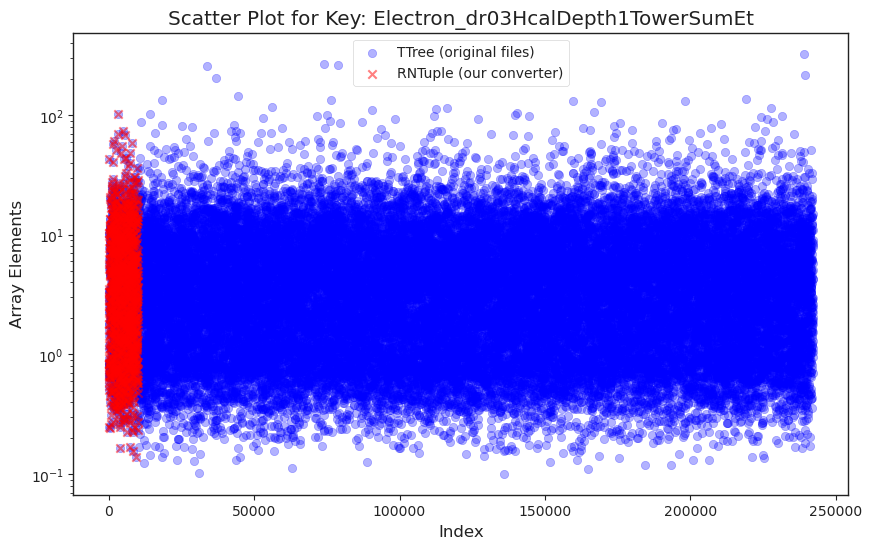

[Electron_dr03TkSumPt] ak comparison ERROR
tt:  [[], [0], [3.36, 0, 0, 0], [0], [0, 0], ..., [0, 0], [0, 0], [0], [0], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0], [3.36, 0, 0, 0], [0], [0, 0], [...], ..., [0, 0], [0], [0], [0], [0]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


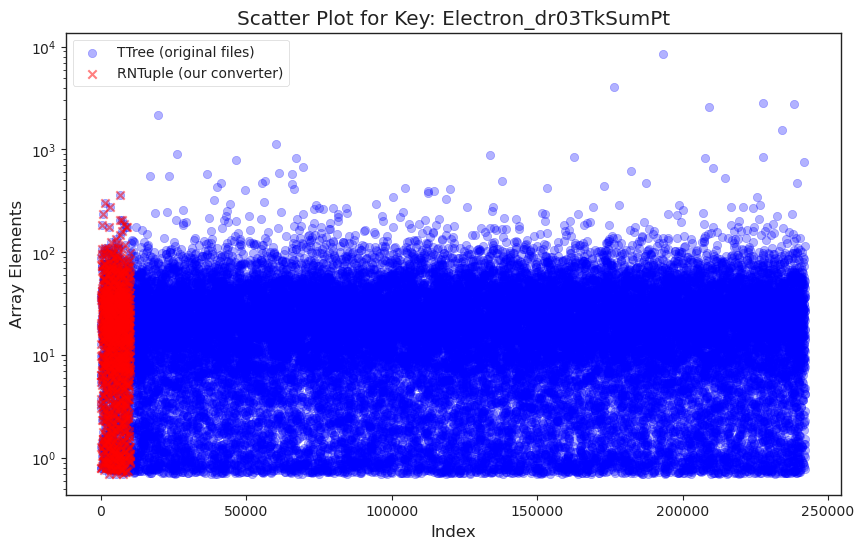

[Electron_dr03TkSumPtHEEP] ak comparison ERROR
tt:  [[], [0], [3.36, 0, 0, 0], [0], [0, 0], ..., [0, 0], [0, 0], [0], [0], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0], [3.36, 0, 0, 0], [0], [0, 0], [...], ..., [0, 0], [0], [0], [0], [0]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


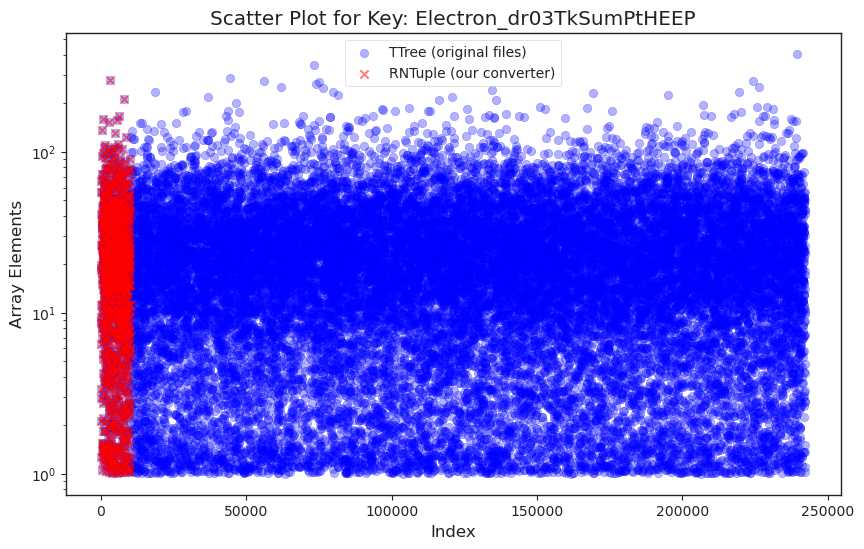

[Electron_dxy] ak comparison ERROR
tt:  [[], [0.00187], [-0.00159, -0.00251, ..., -0.0807], ..., [0.000826], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0.00187], [-0.00159, -0.00251, ..., -0.0807], ..., [-0.0127], [-0.00392]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


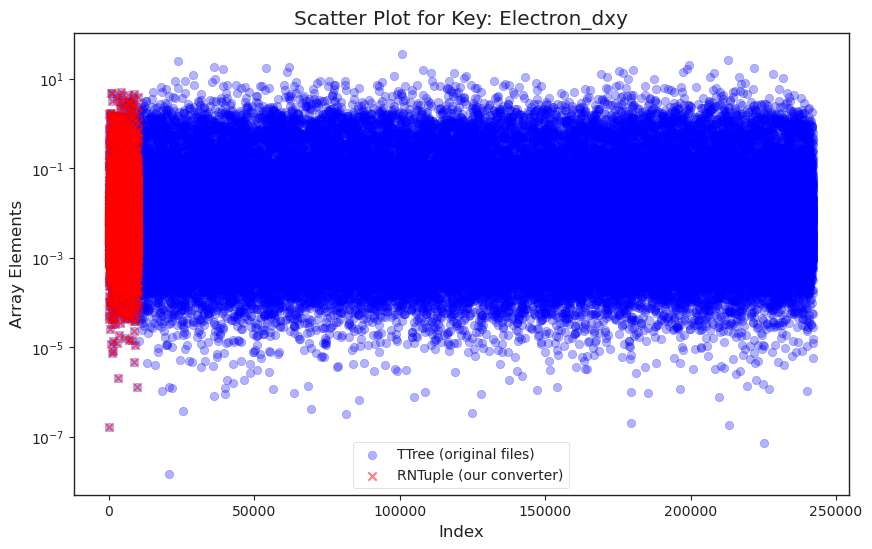

[Electron_dxyErr] ak comparison ERROR
tt:  [[], [0.00397], [0.00339, 0.00397, 0.00296, 0.00793], ..., [0.0032], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0.00397], [0.00339, 0.00397, ..., 0.00793], ..., [0.00415], [0.00195]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


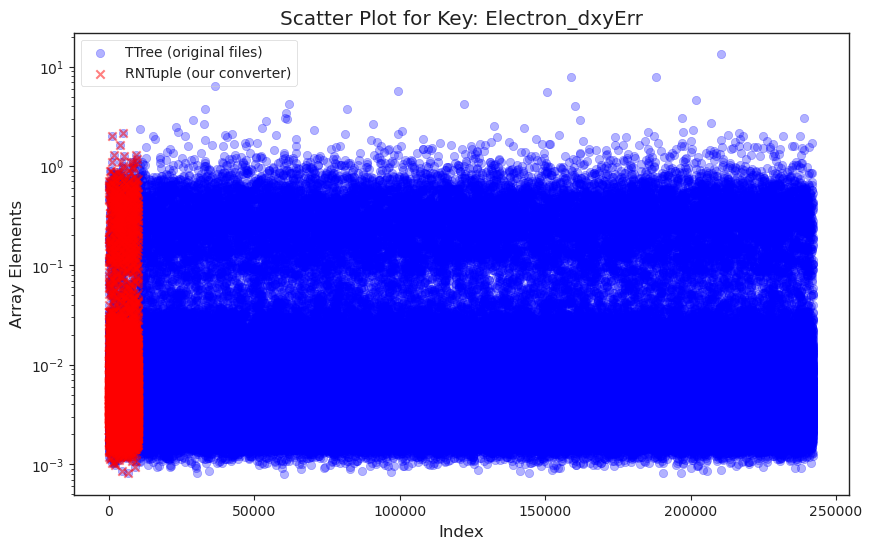

[Electron_dz] ak comparison ERROR
tt:  [[], [-0.00327], [0.000894, 0.00936, 0.00413, 0.655], ..., [-0.00323], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [-0.00327], [0.000894, 0.00936, ..., 0.655], ..., [-0.0851], [0.0035]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


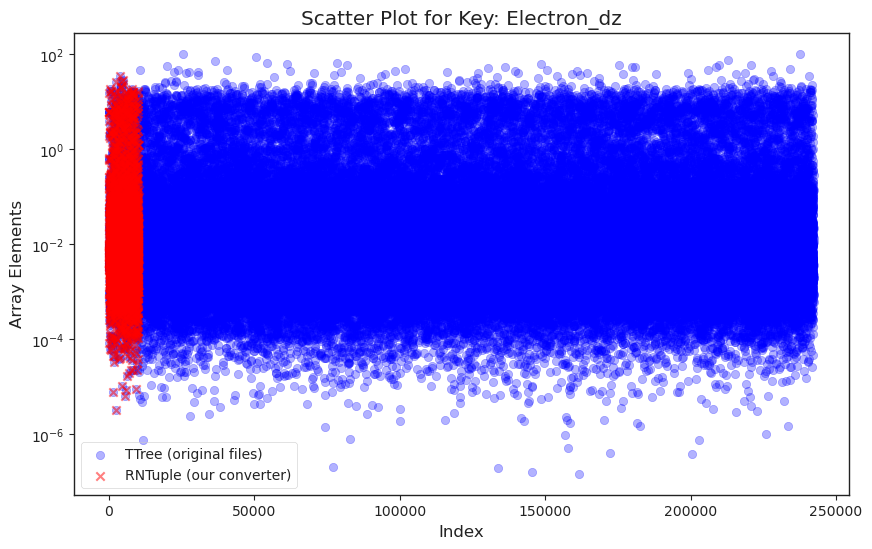

[Electron_dzErr] ak comparison ERROR
tt:  [[], [0.00403], [0.00476, 0.00793, 0.00369, 0.00879], ..., [0.00415], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0.00403], [0.00476, 0.00793, ..., 0.00879], ..., [0.0047], [0.00446]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


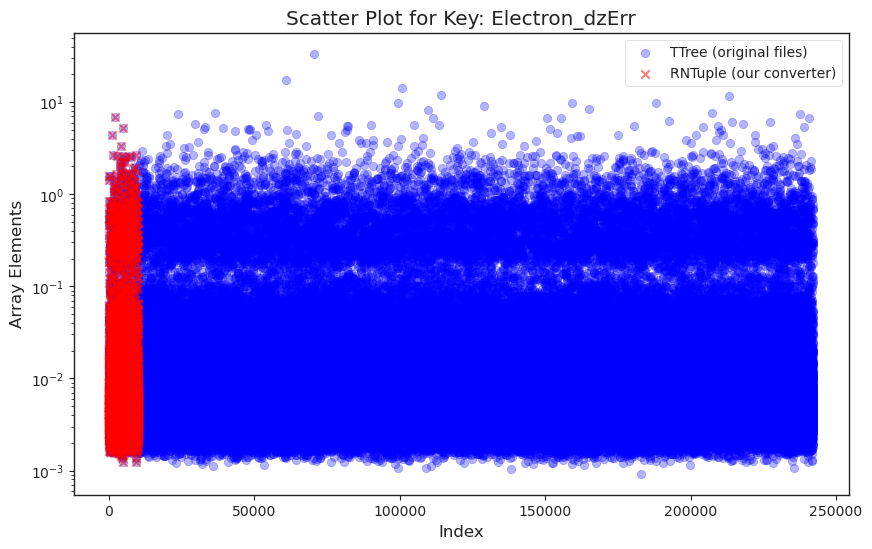

[Electron_eInvMinusPInv] ak comparison ERROR
tt:  [[], [-0.00381], [-0.0274, -0.00233, 0.00296, 0.0391], ..., [0.0326], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [-0.00381], [-0.0274, -0.00233, ..., 0.0391], ..., [-0.0674], [-0.000773]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


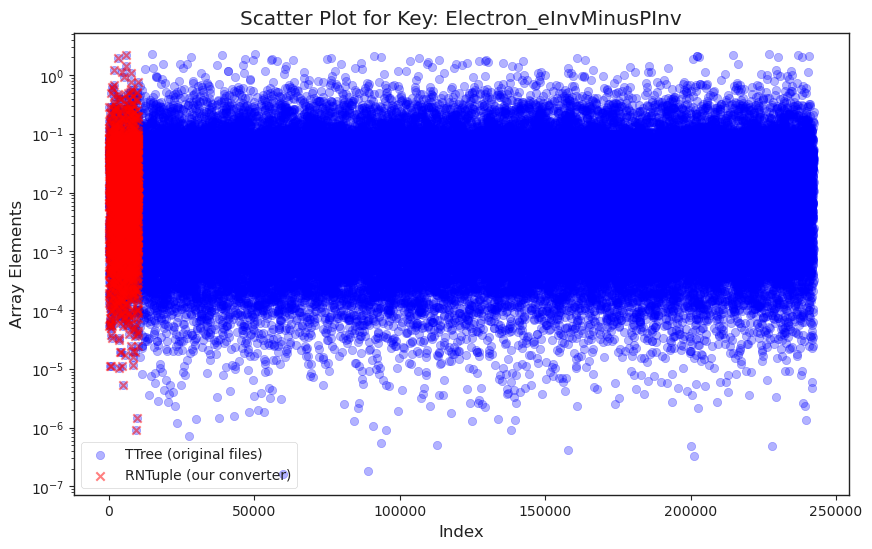

[Electron_energyErr] ak comparison ERROR
tt:  [[], [0.457], [8.62, 3.97, 1.52, 2.38], [4.25], ..., [...], [3.75], [1.33], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0.457], [8.62, 3.97, 1.52, 2.38], [4.25], ..., [5.31], [1.11], [2.84]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


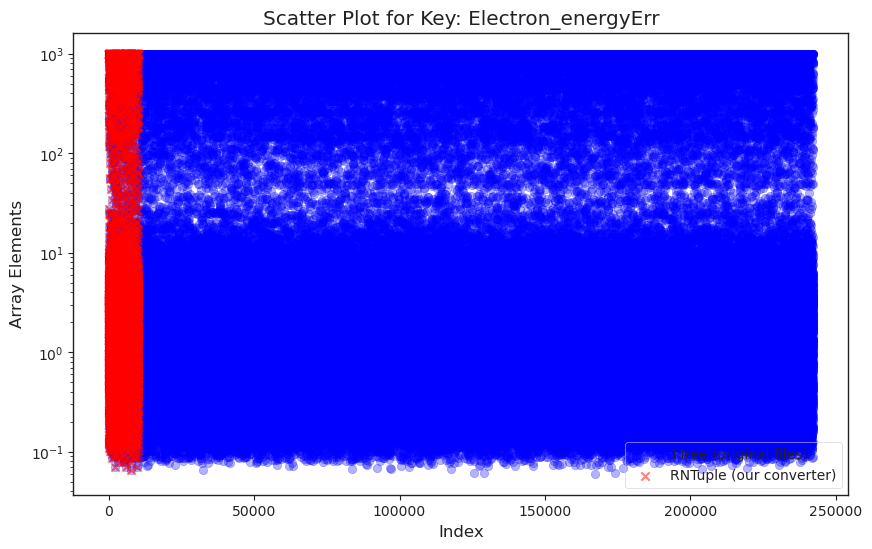

[Electron_eta] ak comparison ERROR
tt:  [[], [0.933], [-1.38, -2.34, 1.19, -1.68], [1.93], ..., [1.61], [1.19], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0.933], [-1.38, -2.34, 1.19, -1.68], [1.93], ..., [1.9], [-0.0948], [1.3]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


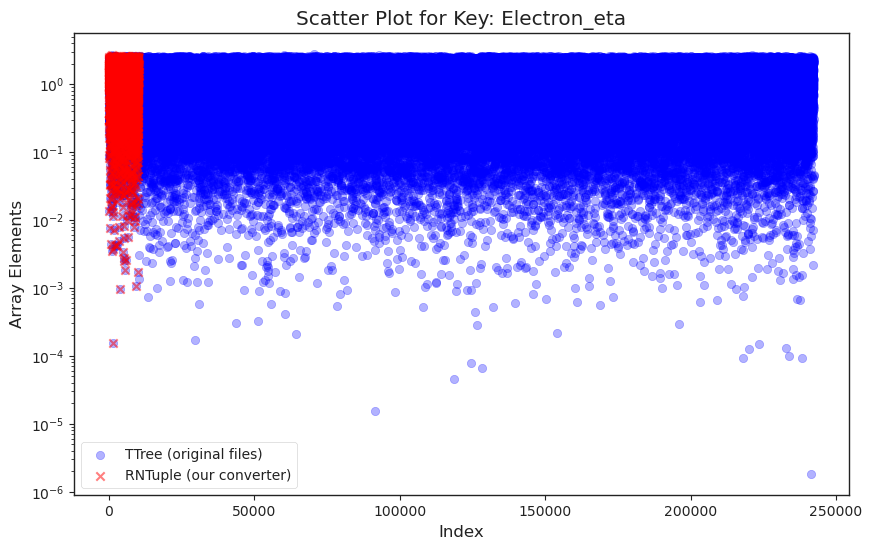

[Electron_genPartFlav] ak comparison ERROR
tt:  [[], [0], [0, 0, 1, 0], [1], [0, 5], [...], ..., [0, 0], [0, 5], [0], [0], []] Type: 188600 * var * uint8. Count of elements: 242252
rn:  [[], [0], [0, 0, 1, 0], [1], [0, 5], [1, ...], ..., [0, 0], [1], [0], [0], [1]] Type: 188600 * var * uint8. Count of elements: 10145
Len of rn after ravel: 10145


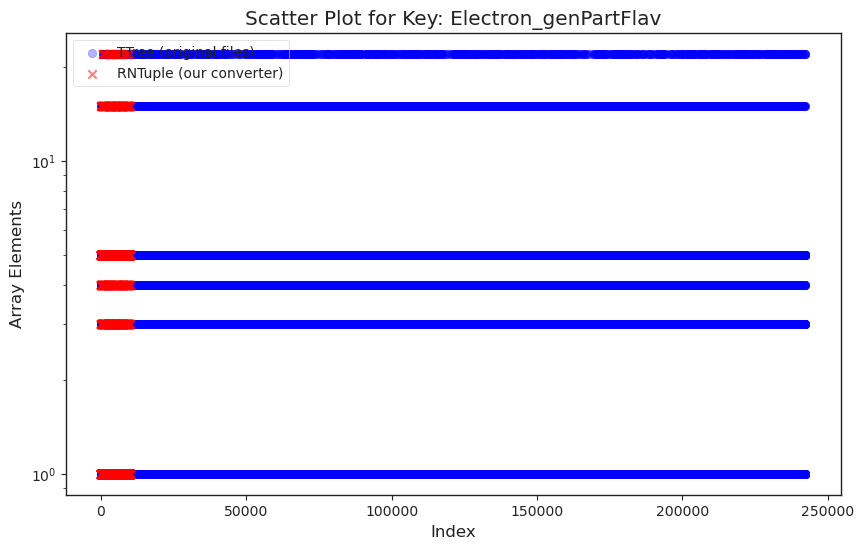

[Electron_genPartIdx] ak comparison ERROR
tt:  [[], [-1], [-1, -1, 15, -1], [13], [-1, 40], ..., [-1, 43], [-1], [-1], []] Type: 188600 * var * int32. Count of elements: 242252
rn:  [[], [-1], [-1, -1, 15, -1], [13], [-1, 40], ..., [...], [17], [-1], [-1], [14]] Type: 188600 * var * int32. Count of elements: 10145
Len of rn after ravel: 10145


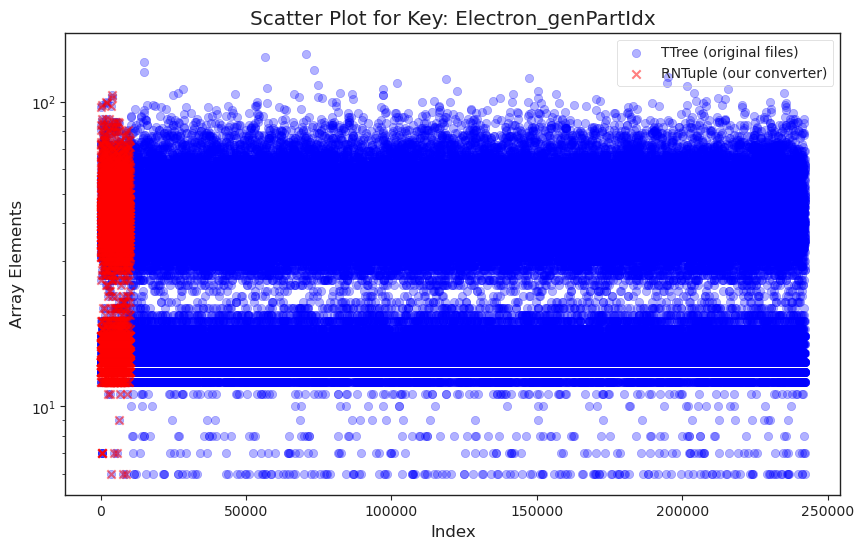

[Electron_hoe] ak comparison ERROR
tt:  [[], [0], [0.108, 0.0735, 0.0686, 0], [0], [...], ..., [0, 0], [0], [0], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0], [0.108, 0.0735, 0.0686, 0], [0], ..., [0.107], [1.45], [0], [0]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


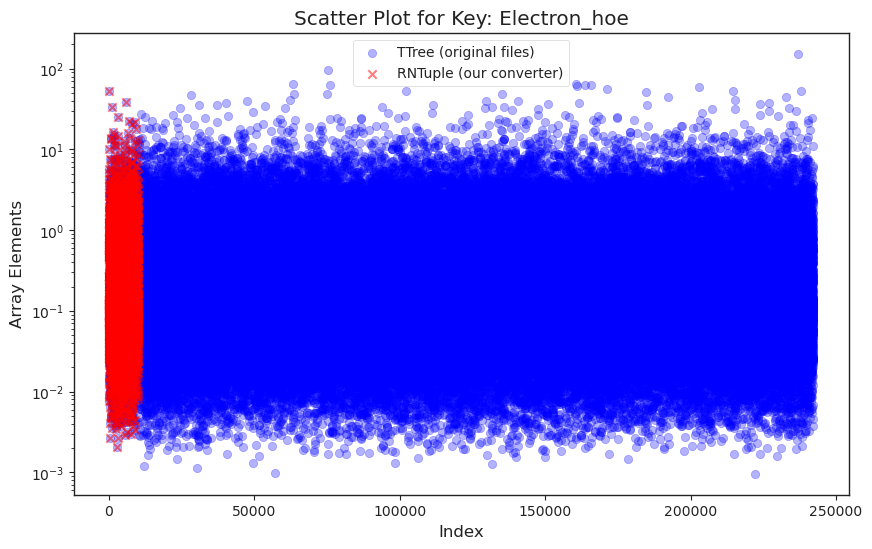

[Electron_ip3d] ak comparison ERROR
tt:  [[], [0.00291], [0.00165, 0.00308, 0.00358, 0.25], ..., [0.0386], [0.00199], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0.00291], [0.00165, 0.00308, 0.00358, 0.25], ..., [0.0856], [0.0043]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


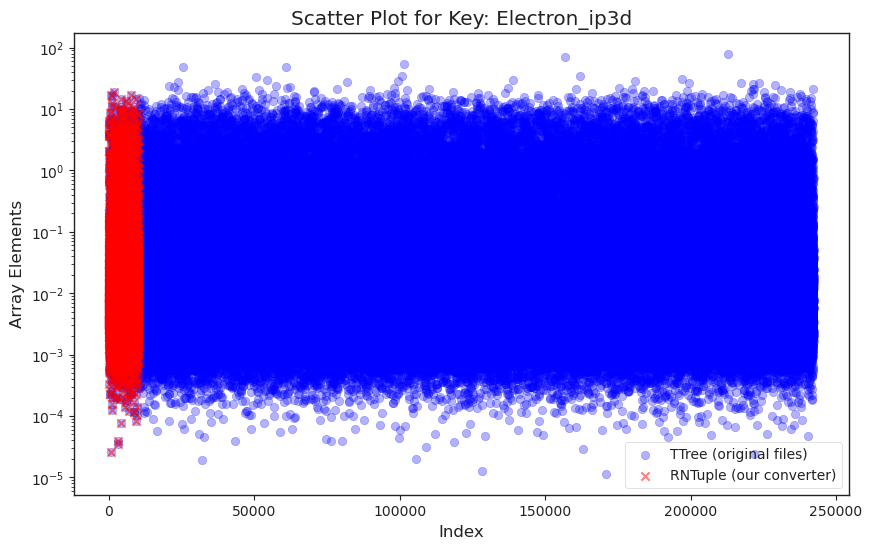

[Electron_isPFcand] ak comparison ERROR
tt:  [[], [False], [True, True, True, True], [True], ..., [...], [True], [True], []] Type: 188600 * var * bool. Count of elements: 242252
rn:  [[], [False], [True, True, True, True], [True], ..., [True], [False], [True]] Type: 188600 * var * bool. Count of elements: 10145
Len of rn after ravel: 10145


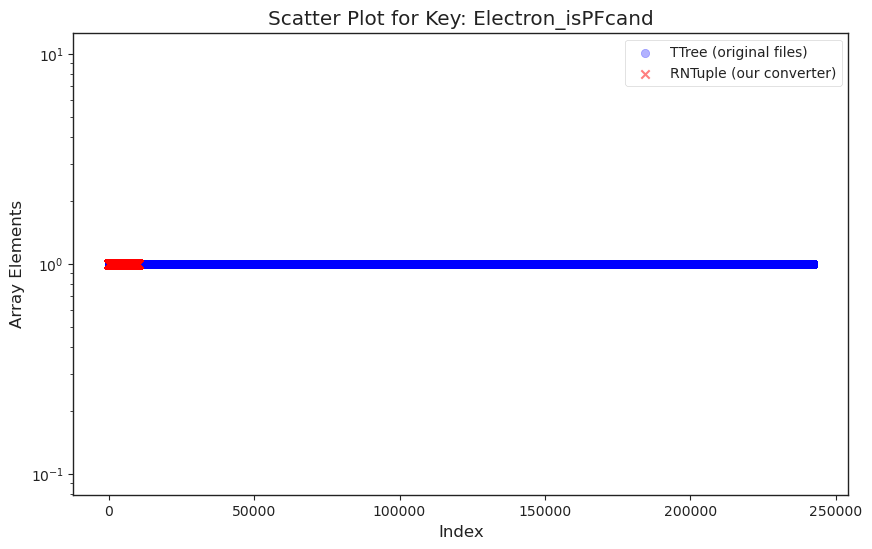

[Electron_jetIdx] ak comparison ERROR
tt:  [[], [2], [1, 2, 4, 1], [0], [4, 5], [...], ..., [3, 1], [1, 1], [5], [4], []] Type: 188600 * var * int32. Count of elements: 242252
rn:  [[], [2], [1, 2, 4, 1], [0], [4, 5], [5, ...], ..., [1, 5], [7], [0], [3], [3]] Type: 188600 * var * int32. Count of elements: 10145
Len of rn after ravel: 10145


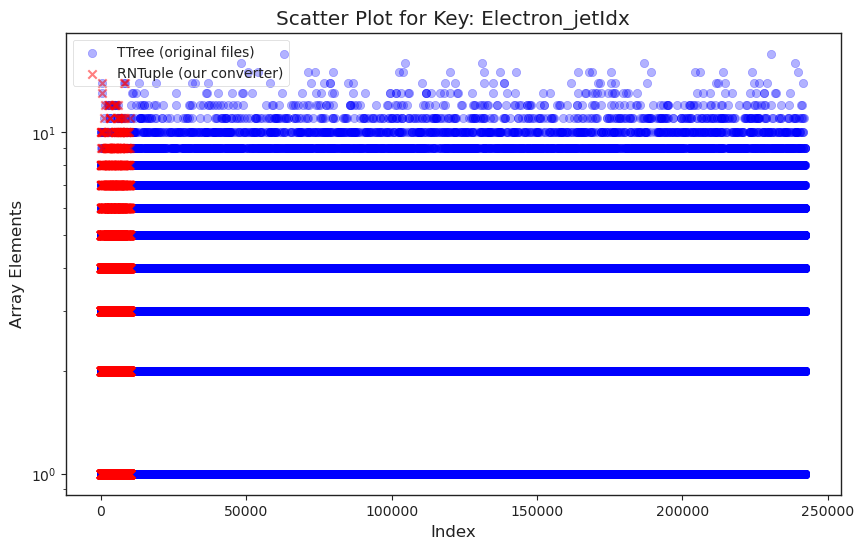

[Electron_jetNDauCharged] ak comparison ERROR
tt:  [[], [6], [4, 5, 1, 1], [1], [4, 5], [...], ..., [3, 8], [5, 5], [4], [3], []] Type: 188600 * var * uint8. Count of elements: 242252
rn:  [[], [6], [4, 5, 1, 1], [1], [4, 5], [1, ...], ..., [10, 1], [1], [7], [3], [1]] Type: 188600 * var * uint8. Count of elements: 10145
Len of rn after ravel: 10145


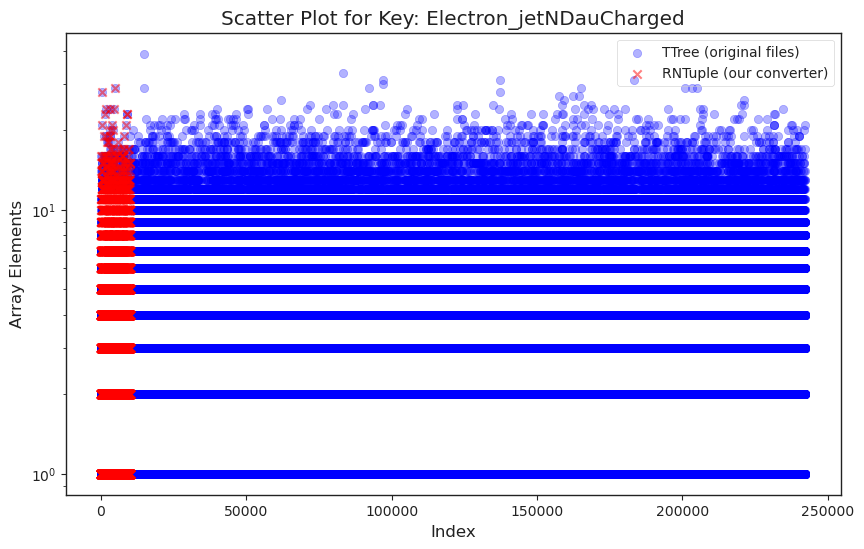

[Electron_jetPtRelv2] ak comparison ERROR
tt:  [[], [0.672], [5.14, 7.23, 2.44, 3.8], [16.8], ..., [...], [0.699], [1.63], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [0.672], [5.14, 7.23, 2.44, 3.8], [16.8], ..., [0.562], [6.75], [10.2]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


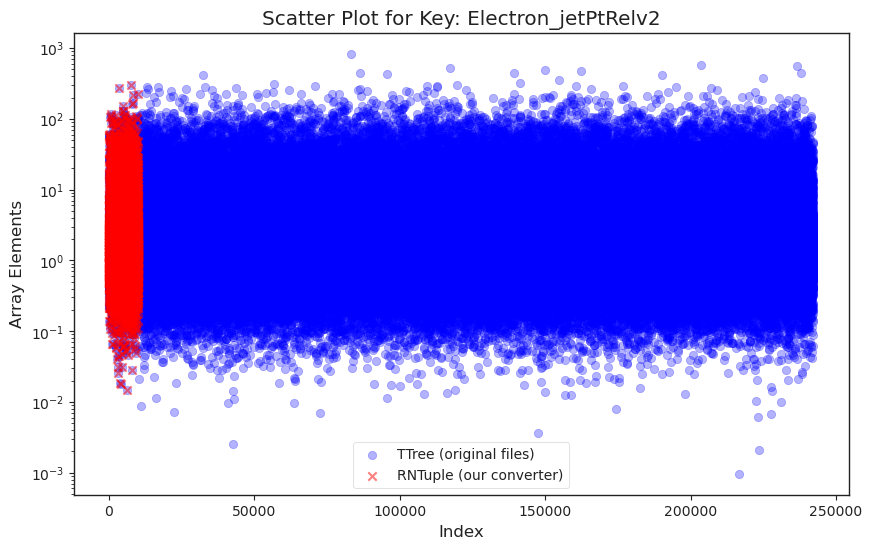

[Electron_jetRelIso] ak comparison ERROR
tt:  [[], [3.94], [0.602, 1.19, 0.134, 11.4], [0.042], ..., [1.65], [0.504], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [3.94], [0.602, 1.19, 0.134, 11.4], [0.042], ..., [3.37], [1.5], [0.0581]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


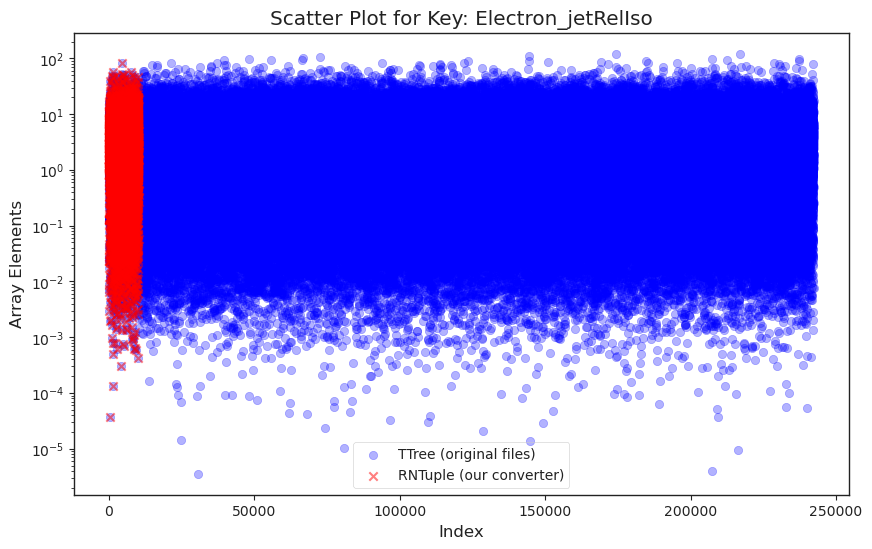

[Electron_lostHits] ak comparison ERROR
tt:  [[], [0], [0, 0, 0, 1], [0], [0, 0], [...], ..., [0, 0], [0, 0], [1], [0], []] Type: 188600 * var * uint8. Count of elements: 242252
rn:  [[], [0], [0, 0, 0, 1], [0], [0, 0], [0, ...], ..., [0, 0], [0], [0], [0], [0]] Type: 188600 * var * uint8. Count of elements: 10145
Len of rn after ravel: 10145


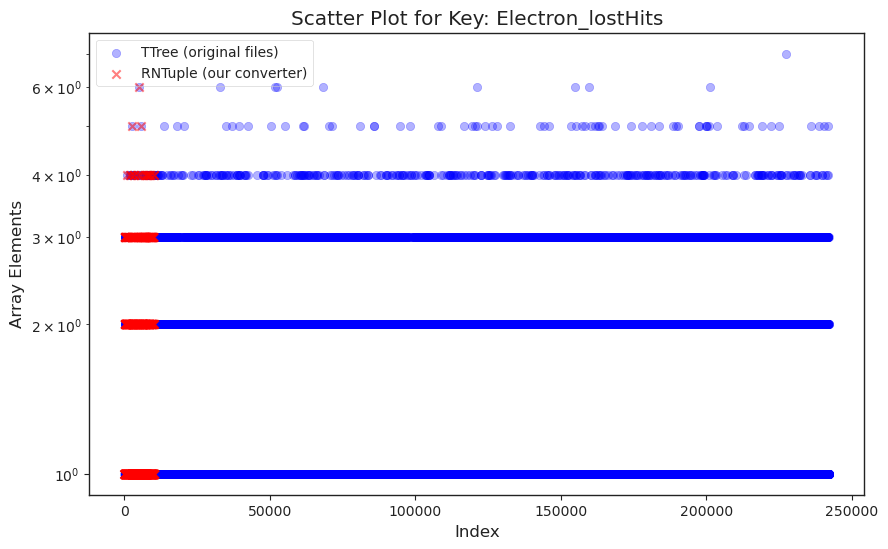

[Electron_mass] ak comparison ERROR
tt:  [[], [-0.00246], [-0.0202, -0.0341, 0.0118, -0.00329], ..., [0.00463], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [-0.00246], [-0.0202, -0.0341, ..., -0.00329], ..., [-0.00531], [0.0179]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


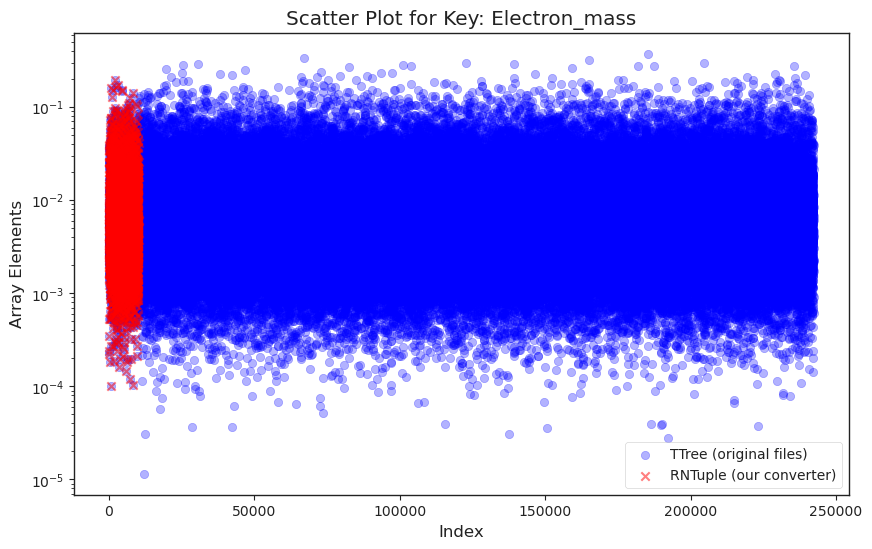

[Electron_miniPFRelIso_all] ak comparison ERROR
tt:  [[], [3.11e+03], [487, 1.17e+03, 1.26e+03, 3.51e+03], ..., [1.9e+03], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [3.11e+03], [487, 1.17e+03, ..., 3.51e+03], ..., [920], [1.16e+03], [951]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


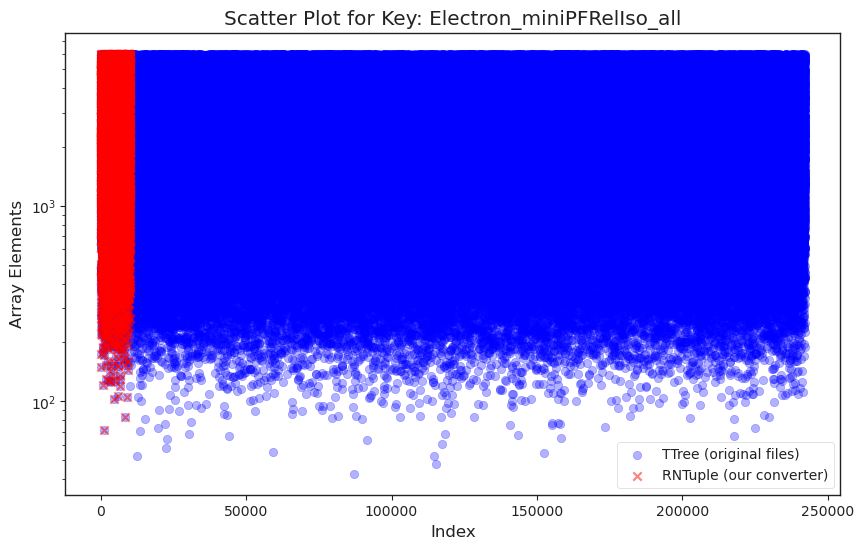

[Electron_miniPFRelIso_chg] ak comparison ERROR
tt:  [[], [1.04e+03], [162, 389, 419, 1.17e+03], [125], ..., [1.37e+03], [632], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [1.04e+03], [162, 389, 419, 1.17e+03], [125], ..., [307], [385], [317]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


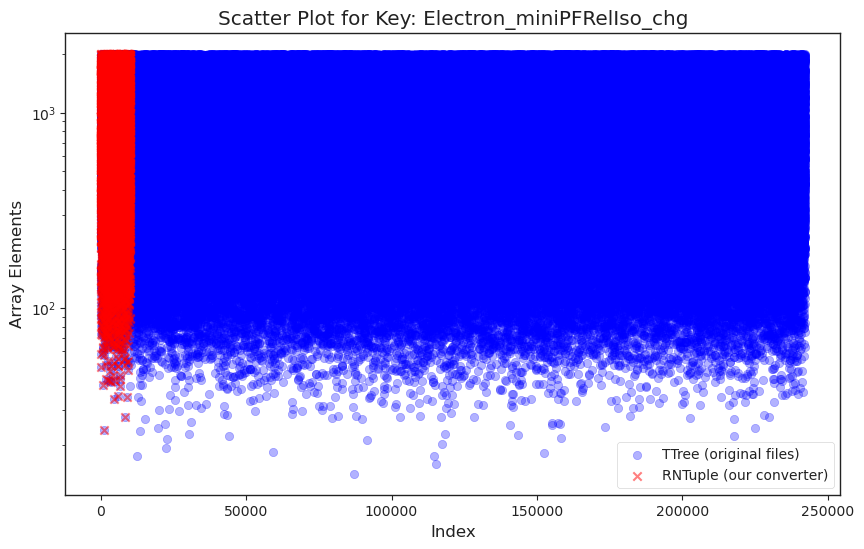

[Electron_mvaFall17V2Iso] ak comparison ERROR
tt:  [[], [-0.99], [-1, -0.765, 0.997, -1], [1], ..., [...], [-0.454], [-0.999], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [-0.99], [-1, -0.765, 0.997, -1], [1], ..., [0.755], [-1], [-0.987], [1]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


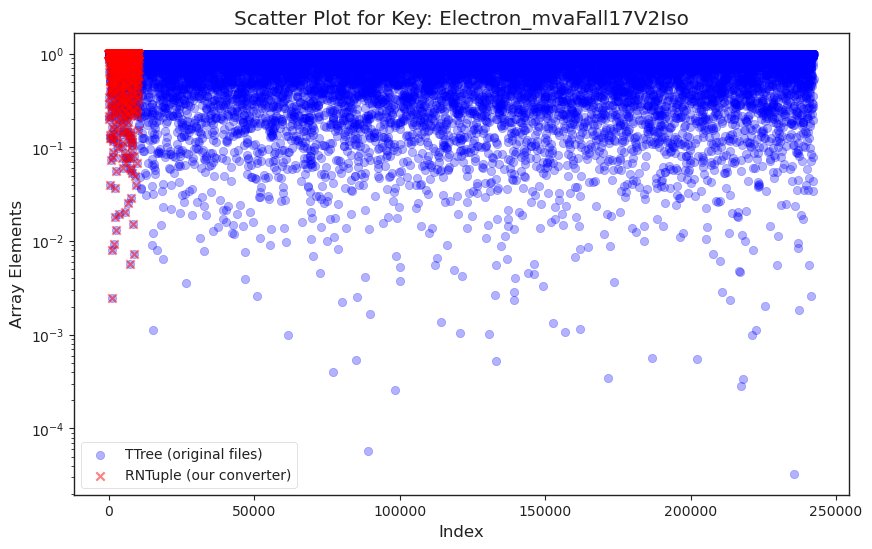

[Electron_mvaFall17V2Iso_WP80] ak comparison ERROR
tt:  [[], [False], [False, False, False, False], [True], ..., [False], [False], []] Type: 188600 * var * bool. Count of elements: 242252
rn:  [[], [False], [False, False, False, False], ..., [False], [False], [True]] Type: 188600 * var * bool. Count of elements: 10145
Len of rn after ravel: 10145


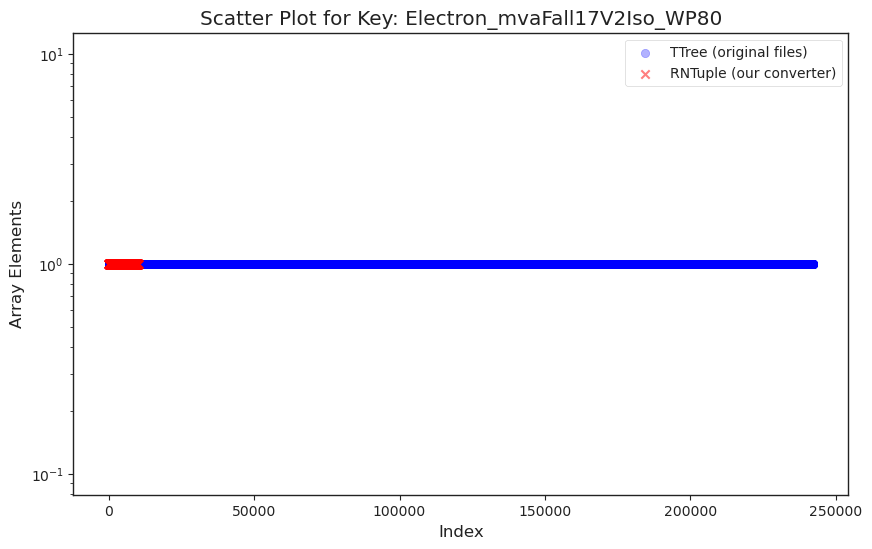

[Electron_mvaFall17V2Iso_WP90] ak comparison ERROR
tt:  [[], [False], [False, False, False, False], [True], ..., [False], [False], []] Type: 188600 * var * bool. Count of elements: 242252
rn:  [[], [False], [False, False, False, False], ..., [False], [False], [True]] Type: 188600 * var * bool. Count of elements: 10145
Len of rn after ravel: 10145


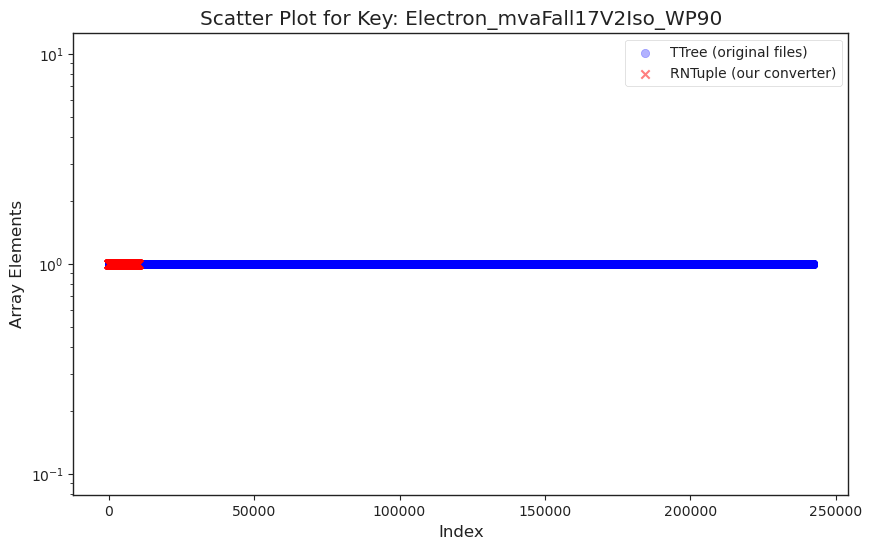

[Electron_mvaFall17V2Iso_WPL] ak comparison ERROR
tt:  [[], [False], [False, False, True, False], [True], ..., [False], [False], []] Type: 188600 * var * bool. Count of elements: 242252
rn:  [[], [False], [False, False, True, False], ..., [False], [False], [True]] Type: 188600 * var * bool. Count of elements: 10145
Len of rn after ravel: 10145


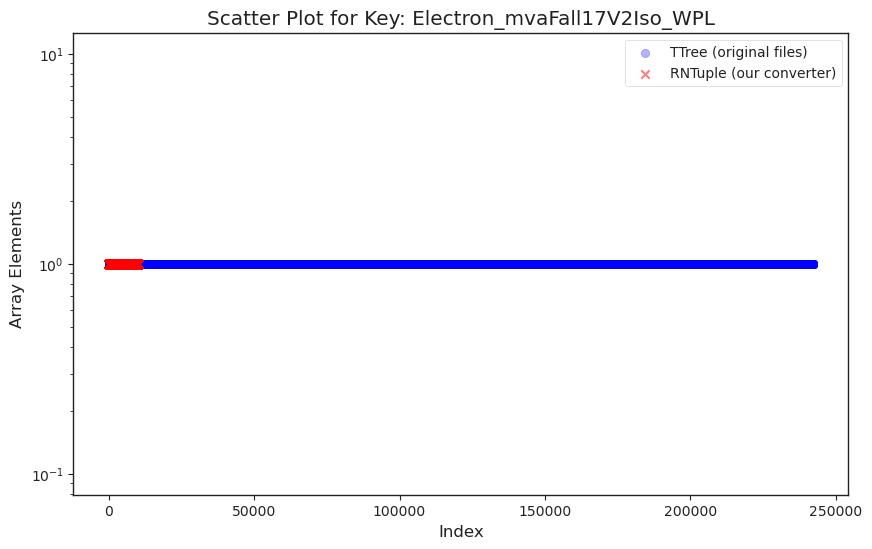

[Electron_mvaFall17V2noIso] ak comparison ERROR
tt:  [[], [-0.945], [-0.995, 0.986, 0.999, -1], [1], ..., [0.564], [-0.946], []] Type: 188600 * var * float32. Count of elements: 242252
rn:  [[], [-0.945], [-0.995, 0.986, 0.999, -1], [1], ..., [-1], [0.669], [1]] Type: 188600 * var * float32. Count of elements: 10145
Len of rn after ravel: 10145


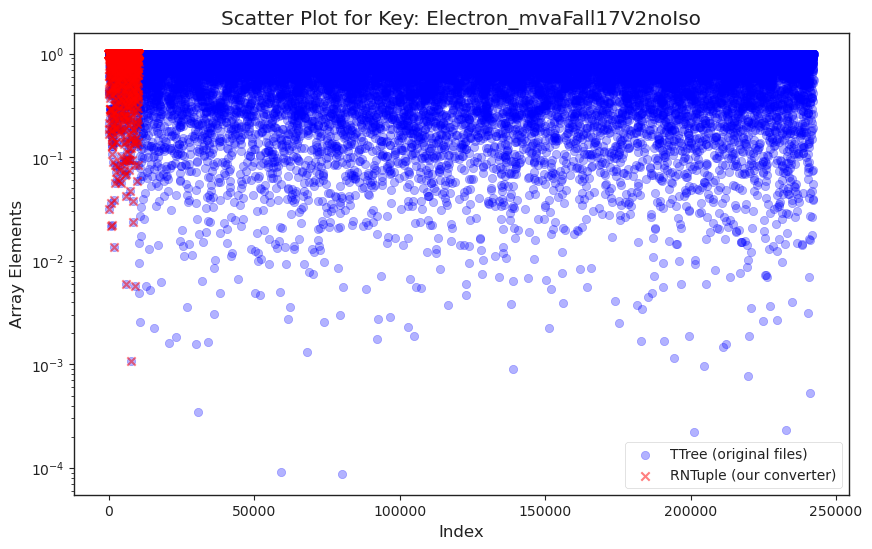

[Electron_mvaFall17V2noIso_WP80] ak comparison ERROR
tt:  [[], [False], [False, False, False, False], [True], ..., [False], [False], []] Type: 188600 * var * bool. Count of elements: 242252
rn:  [[], [False], [False, False, False, False], ..., [False], [False], [True]] Type: 188600 * var * bool. Count of elements: 10145
Len of rn after ravel: 10145


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f9da07a8400>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

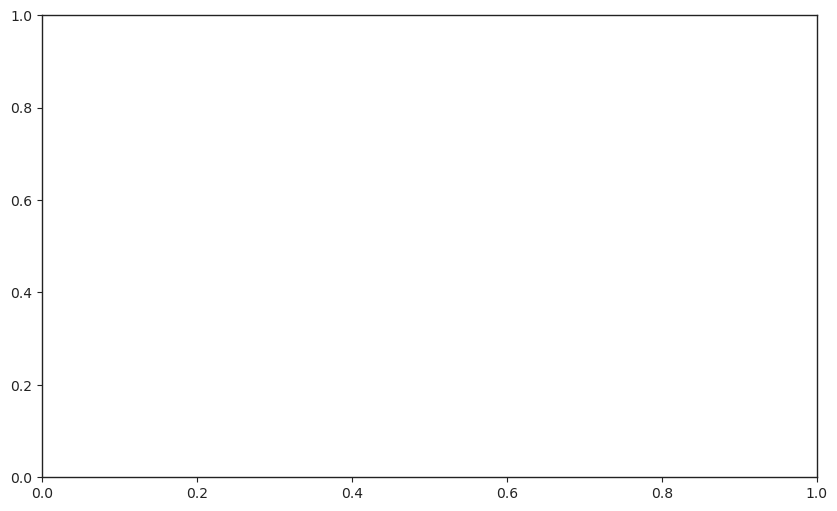

In [4]:
print("Starting cell...")

# file = all_files[1]

events_tt = events_list[0]
events_rn = events_list[1]



# # Various available properties:
# print("Name: ", events.name)
# print("header: ", events.header)
# print("footer: ", events.footer)
# print("num_entries: ", events.num_entries)
# print("len of field_names: ", len(events.field_names))
# print("keys: ", len(events.keys()))

# print(" field_names: ", events.fields)


# print("column_records: ", events.column_records[:10])
# print("keys: ", events.keys()[:10])
# print("_column_records_dict: ", events._column_records_dict)
# print("_related_ids: ", events._related_ids)
# print("page_list_envelopes: ", events.page_list_envelopes)


# # Experimenting with array access:
# array = events.arrays(filter_names=["Electron_pt", "Electron_eta"])[:20]
# print("events.arrays(): ", events.arrays())
# print("----------")
# print("events.arrays().show(): ", events.arrays().show())
# print("----------")
# # tree = uproot.open(file)



# Must be sorted, because otherwise the order is different.
keys_tt = sorted(events_tt.keys(), key=str.lower)
keys_rn = sorted(events_rn._keys, key=str.lower)

print(f"TTree keys length: {len(keys_tt)}. RNTuple keys length: {len(keys_rn)}")
# print("")

def calculate_abs_difference(flat_ls1, flat_ls2):
    # Calculate max(abs(x2-x1)):
    # Ensure the arrays are of the same length
    min_length = min(len(flat_ls1), len(flat_ls2))
    
    # Truncate arrays to the common length
    flat_ls1_same_len = flat_ls1[:min_length]
    flat_ls2_same_len = flat_ls2[:min_length]
    
    # Calculate the absolute differences
    abs_differences = np.abs(np.array(flat_ls1_same_len) - np.array(flat_ls2_same_len))
    
    # Calculate the maximum absolute difference
    max_abs_diff = np.max(abs_differences)
    print(f"Maximum absolute difference for key '{key}': {max_abs_diff}")

def draw_graph_flatten(key, arrays_tt, arrays_rn):
    # Flatten the arrays
    flat_tt = ak.ravel(arrays_tt).to_list()
    flat_rn = ak.ravel(arrays_rn).to_list()
    
    
    print("Len of rn after ravel:", len(ak.ravel(arrays_rn)))
    
    
    
    # # Export mathcing sublists to a CSV file using pandas:
    df = pd.DataFrame({
        'flat_tt': pd.Series(flat_tt),
        'flat_rn': pd.Series(flat_rn)
        # 'tt': matching_sublists_tt,
        # 'rn': matching_sublists_rn
    })
    df.to_csv(f'{key}_flattened.csv')
    
    # Create a range for the x-axis based on the length of the arrays
    x_indices_tt = list(range(len(flat_tt)))
    x_indices_rn = list(range(len(flat_rn)))
    
    
    
    # Plot the scatter plot using the indices as x-values and array elements as y-values
    plt.figure(figsize=(10, 6))
    plt.scatter(x_indices_tt, flat_tt, color='blue', alpha=0.3, label='TTree (original files)')
    plt.scatter(x_indices_rn, flat_rn, color='red', alpha=0.5, label='RNTuple (our converter)', marker="x")
    
    plt.yscale('log')
    
    # Labeling
    plt.title(f"Scatter Plot for Key: {key}")
    plt.xlabel('Index')
    plt.ylabel('Array Elements')
    plt.legend()
    
    # Display the plot
    plt.show()
    
def draw_graph_grouped(key, arrays_tt, arrays_rn):
    # Flatten the arrays
    # flat_tt = ak.ravel(arrays_tt).to_list()
    # flat_rn = ak.ravel(arrays_rn).to_list()
    
    indices_of_matching_sublists = []
    match_results = []
    matching_sublists_tt = []
    matching_sublists_rn = []

    
    for i, sublist_rn in enumerate(arrays_rn):
        indices_of_matching_sublists.append(i)
        try:
            assert (len(arrays_tt[i]) == len(arrays_rn[i]) and all(arrays_tt[i] == arrays_rn[i]))
            match_results.append(1)
            matching_sublists_tt.append(arrays_tt[i])
            matching_sublists_rn.append(arrays_rn[i])

        except:
            # print(f"[{i}]",arrays_tt[i], "---", arrays_rn[i])
            match_results.append(0)
            matching_sublists_tt.append(arrays_tt[i])
            matching_sublists_rn.append(arrays_rn[i])

#     print("TT indices len:", len(x_indices_tt))
#     print("RN indices len:", len(x_indices_rn))
    
#     print("TT flat_tt len:", len(flat_tt))
#     print("RN flat_rn len:", len(flat_rn))

    
    # Plot the scatter plot using the sublist indices as x-values and array elements as y-values
    plt.figure(figsize=(10, 6))
    # plt.scatter(x_indices_tt, flat_tt, color='blue', alpha=0.3, label='TTree (original files)')
    # plt.scatter(x_indices_rn, flat_rn, color='red', alpha=0.5, label='RNTuple (our converter)', marker="x")
    plt.scatter(indices_of_matching_sublists, match_results, s=2, color='green', alpha=0.2, label='RNTuple (our converter)')
    
    # # Export the values to a CSV file using pandas
    # df = pd.DataFrame({
    #     'Index': indices_of_matching_sublists,
    #     'Match Result': match_results
    # })
    # df.to_csv(f'{key}_match_results.csv', index=False)
    
    # # # Export mathcing sublists to a CSV file using pandas:
    # df = pd.DataFrame({
    #     'Match Result': match_results,
    #     'Index': indices_of_matching_sublists,
    #     'tt': matching_sublists_tt,
    #     'rn': matching_sublists_rn
    # })
    # df.to_csv(f'{key}_sublists.csv', index=False)

    
    # plt.xscale('log')
    
    # Labeling
    plt.title(f"Scatter Plot for Key: {key}")
    plt.xlabel('Sublist Index')
    plt.ylabel('Does sublist match')
    plt.legend()
    
    # Display the plot
    plt.show()

def compare_key_lists(ls1, ls2):
    match_count = 0
    mismatch_count = 0
    
    ak_match_count = 0
    ak_mismatch_count = 0
    ak_error_count = 0
    
    count_of_all_tt_elements = 0
    count_of_all_rn_elements = 0
    
    for i in range(len(ls1)):
        if keys_tt[i] == keys_rn[i]:
            key = keys_tt[i]
            match_count+=1
            # print(f"\r{i+1}/{len(ls1)}", f" {keys_tt[i]}", end="") # Progress indication without printing too many lines
            # print(f"{i+1}/{len(ls1)}", f" {keys_tt[i]}: ")
            arrays_tt = events_tt.arrays([key])[key]
            arrays_rn = events_rn.arrays([key])[key]
            
            el_count_tt = len(ak.ravel(arrays_tt))
            el_count_rn = len(ak.ravel(arrays_rn))
            
            
            
            # print(f"TT elements: {count_of_all_tt_elements}")
            # print(f"RN elements: {count_of_all_rn_elements}")

            # Check if arrays are equal:
            try:
                are_equal = ak.all(arrays_tt == arrays_rn)
                if are_equal:
                    ak_match_count += 1
                    print(f"[{key}]", "ak arrays are equal")
                elif not are_equal:
                    count_of_all_tt_elements+=el_count_tt
                    count_of_all_rn_elements+=el_count_rn
                    ak_mismatch_count += 1
                    print(f"[{key}]", "ak comparison MISMATCH")
                    print("tt: ", arrays_tt, f"Type: {ak.type(arrays_tt)}. Count of elements: {el_count_tt}")
                    print("rn: ", arrays_rn, f"Type: {ak.type(arrays_rn)}. Count of elements: {el_count_rn}")
                
                # print("Arrays are equal: ", are_equal)  # Output: True
            except:
                count_of_all_tt_elements+=el_count_tt
                count_of_all_rn_elements+=el_count_rn
                ak_error_count += 1
                print(f"[{key}]", "ak comparison ERROR")
                print("tt: ", arrays_tt, f"Type: {ak.type(arrays_tt)}. Count of elements: {el_count_tt}")
                print("rn: ", arrays_rn, f"Type: {ak.type(arrays_rn)}. Count of elements: {el_count_rn}")
                # draw_graph_grouped(key, arrays_tt, arrays_rn)
                draw_graph_flatten(key, arrays_tt, arrays_rn)
                


        else:
            mismatch_count+=1
            # print("Mismatch: ", keys_tt[i], "---", keys_rn[i])
    print(f"Keys comparison statistics: matched count: {match_count}; mismatch count: {mismatch_count}")
    print(f"ak array comparison statistics: matched count: {ak_match_count}; mismatch count: {ak_mismatch_count}; errors: {ak_error_count}")


compare_key_lists(keys_tt, keys_rn)


# for key in events: 
#     # branch = events.arrays([key])[key]
#     print(key)


## Things that do not work:
# print("Show(): ", events.show()) # 'Model_ROOT_3a3a_Experimental_3a3a_RNTuple' object has no attribute 'show'
# for key, branch in events.iteritems(): # Does not work with RNTuple. AttributeError: no field named 'iteritems'. However, it does work with TTree.
# for key, branch in events.arrays().iteritems(): # Does not work both with TTree or RNTuple.
# print(list(events.arrays().keys())) # Does not work. No field names keys()




In [151]:
cluster_starts = [md.num_first_entry for md in events_rn.cluster_summaries][1:] # Skip first, because it is 0.
print("Starts of clusters: ", cluster_starts)
print("")
key = "Electron_hoe"
def collect_breaking_points(key):
    step = 2
    for cl_start in cluster_starts:
        for i in range (cl_start-20, cl_start+20, step):
            strt = i
            end = i + step
            arr_tt = events_tt.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]
            arr_rn = events_rn.arrays(filter_names=[key], entry_start=strt, entry_stop=end)[key]
            
            try:
                assert (len(arr_tt) == len(arr_rn) and ak.all(arr_tt == arr_rn))
            except Exception as e:
                print(f"TT array: {arr_tt}")
                print(f"RN array: {arr_rn}")
                print("Index: ", i, f". Failure limits: {(strt, end)}")
                print("")
                
# Example arrays to test error:
arr_1 = ak.Array([[0], []]) 
arr_2 = ak.Array([[0], []])  
assert (len(arr_1) == len(arr_2) and ak.all(arr_1 == arr_2))

collect_breaking_points(key)


Starts of clusters:  [17224, 44433, 71709, 98997, 126243, 153500, 180739]

TT array: [[0], [0.0213, 0.0372]]
RN array: [[], []]
Index:  44431 . Failure limits: (44431, 44433)

TT array: [[0.119], [0.0198]]
RN array: [[], []]
Index:  126241 . Failure limits: (126241, 126243)

TT array: [[0.0443], [0.00703, 0.0393, 0.118]]
RN array: [[], []]
Index:  180737 . Failure limits: (180737, 180739)



In [ ]:
# # Test times for each function:

# import timeit

# # Define the operations as functions
# def array_1():
#     print(events_list[0].arrays(["Electron_pt"])["Electron_pt"])

# def array_1_direct():
#     print(events_list[0]["Electron_pt"].array())

# def array_2():
#     print(events_list[1].arrays(["Electron_pt"])["Electron_pt"])

# def array_2_direct():
#     print(events_list[1]["Electron_pt"].array())

# def array_3():
#     print(events_list[2].arrays(["Electron_pt"])["Electron_pt"])

# def array_3_direct():
#     print(events_list[2]["Electron_pt"].array())

# # Time the operations
# time_1 = timeit.timeit(array_1, number=1)
# print("Time for events1.arrays(['Electron_pt'])['Electron_pt']: ", time_1)
# time_1_direct = timeit.timeit(array_1_direct, number=1)
# print("Time for events1['Electron_pt'].array(): ", time_1_direct)

# print("*****")

# time_2 = timeit.timeit(array_2, number=1)
# print("Time for events2.arrays(['Electron_pt'])['Electron_pt']: ", time_2)
# time_2_direct = timeit.timeit(array_2_direct, number=1)
# print("Time for events2['Electron_pt'].array(): ", time_2_direct)

# print("*****")

# time_3 = timeit.timeit(array_3, number=1)
# print("Time for events3.arrays(['Electron_pt'])['Electron_pt']: ", time_3)
# time_3_direct = timeit.timeit(array_3_direct, number=1)
# print("Time for events3['Electron_pt'].array(): ", time_3_direct)








In [ ]:
# create the task graph to build a histogram
print("Calculating trijet mass...")
reconstructed_top_mass = calculate_trijet_mass(events_list[0])
print("hist_reco_mtop...")
hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)
print("Finished cell")

and then once we're ready we can execute the task graph with `.compute()` to get our visualization

In [ ]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

In [ ]:
# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175, 0, 10000, colors=["grey"], linestyle="dotted")
ax.text(180, 150, "$m_{t} = 175$ GeV")
ax.set_xlim([0, 375])
ax.set_ylim([0, 8000])

fig.savefig(fig_dir / "trijet_mass.png", dpi=300)
fig

This all matches the (non-Dask) versions of the plots from last summer — see the notebook linked above. Not surprising, but reassuring!

### Time for coffea

We'll first write the functions to compute the observable and do the histogramming using `awkward-dask` and `hist.dask` again

In [ ]:
B_TAG_THRESHOLD = 0.5

# perform object selection
def object_selection(events):
    elecs = events.Electron
    muons = events.Muon
    jets = events.Jet

    electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
    muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                 (muons.pfRelIso04_all < 0.15))
    jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

    # Only keep objects that pass our requirements
    elecs = elecs[electron_reqs]
    muons = muons[muon_reqs]
    jets = jets[jet_reqs]

    return elecs, muons, jets


# event selection for 4j1b and 4j2b
def region_selection(elecs, muons, jets):
    ######### Store boolean masks with PackedSelection ##########
    selections = PackedSelection(dtype='uint64')
    # Basic selection criteria
    selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
    selections.add("atleast_4j", ak.num(jets) >= 4)
    selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
    selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
    # Complex selection criteria
    selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
    selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

    return selections.all("4j1b"), selections.all("4j2b")


# observable calculation for 4j2b
def calculate_m_reco_top(jets):
    # reconstruct hadronic top as bjj system with largest pT
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2,
                                    np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable = ak.flatten(trijet_mass)

    return observable


# create histograms with observables
def create_histograms(events):
    hist_4j1b = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="HT", label=r"$H_T$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    hist_4j2b = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    process = events.metadata["process"]  # "ttbar" etc.
    variation = events.metadata["variation"]  # "nominal" etc.
    process_label = events.metadata["process_label"]  # nicer LaTeX labels

    # normalization for MC
    x_sec = events.metadata["xsec"]
    nevts_total = events.metadata["nevts"]
    lumi = 3378 # /pb
    if process != "data":
        xsec_weight = x_sec * lumi / nevts_total
    else:
        xsec_weight = 1

    elecs, muons, jets = object_selection(events)

    # region selection
    selection_4j1b, selection_4j2b = region_selection(elecs, muons, jets)

    # 4j1b: HT
    observable_4j1b = ak.sum(jets[selection_4j1b].pt, axis=-1)
    hist_4j1b.fill(observable_4j1b, weight=xsec_weight, process=process_label, variation=variation)

    # 4j2b: m_reco_top
    observable_4j2b = calculate_m_reco_top(jets[selection_4j2b])
    hist_4j2b.fill(observable_4j2b, weight=xsec_weight, process=process_label, variation=variation)

    return {"4j1b": hist_4j1b, "4j2b": hist_4j2b}

and prepare the fileset we need

In [ ]:
# fileset preparation
N_FILES_MAX_PER_SAMPLE = 1
# compared to coffea 0.7: list of file paths becomes list of dicts (path: trename)
fileset = utils.file_input.construct_fileset(N_FILES_MAX_PER_SAMPLE)

# fileset = {"ttbar__nominal": fileset["ttbar__nominal"]}  # to only process nominal ttbar
# fileset

Now we can start using `coffea` with its Dask capabilities. One of the things we need to do is to build the full task graph, which requires looping over all the sample variations (`samples`)

In [ ]:
%%time
# pre-process
samples, _ = dataset_tools.preprocess(fileset, step_size=250_000)

# workaround for https://github.com/CoffeaTeam/coffea/issues/1050 (metadata gets dropped, already fixed)
for k, v in samples.items():
    v["metadata"] = fileset[k]["metadata"]

In [ ]:
%%time
# create the task graph
tasks = dataset_tools.apply_to_fileset(create_histograms, samples, uproot_options={"allow_read_errors_with_report": True})

and then we can finally execute the full task graph with Dask

In [ ]:
%%time
# execute
((out, report),) = dask.compute(tasks)  # feels strange that this is a tuple-of-tuple

print(f"total time spent in uproot reading data (or some related metric?): {ak.sum([v['duration'] for v in report.values()]):.2f} s")

To visualize the results, we need to first stack the serperate histograms that were computed individually

In [ ]:
# stack all the histograms together (we processed each sample separately)
full_histogram_4j1b = sum([v["4j1b"] for v in out.values()])
full_histogram_4j2b = sum([v["4j2b"] for v in out.values()])

In [ ]:
artists = full_histogram_4j1b[120j::hist.rebin(2), :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_title(">= 4 jets, 1 b-tag");

fig.savefig(fig_dir / "coffea_4j_1b.png", dpi=300)

In [ ]:
artists = full_histogram_4j2b[:, :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_title(">= 4 jets, >= 2 b-tags");

fig.savefig(fig_dir / "coffea_4j_2b.png", dpi=300)

This is a plot you can compare to the one in the full AGC notebook — you'll notice they look the same. Success!

If we now investigate the task graph for the nominal $t\bar{t}$ sample in the optimzied view, which hides from us some of the complexity of the graph we created.

In [ ]:
tasks[0]["ttbar__nominal"]["4j2b"].visualize(optimize_graph=True)

In [ ]:
# "100 layers is a large task graph" on IRIS-HEP Slack, 100 layers happen quickly!
for region in ["4j1b", "4j2b"]:
    for process, task in tasks[0].items():
        print(f"{process:>30} {region} {len(task[region].dask.layers)}")

In [ ]:
# columns getting read for a given task
dak.necessary_columns(tasks[0]["ttbar__nominal"]["4j2b"])